In [1]:
import numpy as np
import math
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [104]:
noise_max = 0.3
def make_xy_pair(shape):
    y = np.round(np.random.rand(*shape))
    noise = np.random.uniform(low=-noise_max/2, high=noise_max/2, size=(shape))
    x = y - noise
    return x, y

In [3]:
def trapezoidIntegral(vals, ds):
    pass1 = tf.reduce_sum(vals, axis=0)
    pass2 = tf.reduce_sum(vals[1:-1], axis=0)
    return ds/2.0*(pass1+pass2)
def TFconv(image, filt, b):
    return tf.nn.convolution(input=image, filters=filt, padding="SAME") + b
def leakyRelUInv(x):
    shape = x.shape
    zeros = tf.zeros(shape)
    mask = tf.math.greater_equal(x, zeros)
    weighted = x / leakyRelU_weight
    return tf.where(mask, x, weighted)
def uSoln(x0, inFilt, pFilt, b, y):
    t1 = inFilt.shape[0]
    ds = 1.0/(t1-1)
    input_shape = x0.shape
    bzero = tf.zeros([inFilt.shape[4]])
    x = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    u = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    
    with tf.GradientTape() as tape:
        tape.watch(x0)
        u0 = leakyRelUInv(x0)
        u = u.write(0,TFconv(u0, inFilt[0], bzero))

        for h in range(t1-1):
            x = x.write(h, tf.nn.leaky_relu(u.read(h), alpha=leakyRelU_weight))
            zInt = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
            for s in range(h+1):
                zInt = zInt.write(s, TFconv(x.read(s), pFilt[s,h], b[h] / ((h+1)*ds)))
            z = trapezoidIntegral(zInt.stack(), ds)
            u = u.write(h+1, z + TFconv(u0, inFilt[h+1], bzero))
        x = x.write(t1-1,tf.nn.leaky_relu(u.read(t1-1), alpha=leakyRelU_weight))
        
        loss = tf.math.square(x.read(t1-1) - y)
        gradients = tape.gradient(loss, [pFilt, inFilt, b])
        
        return x.read(t1-1), tf.math.reduce_sum(loss), gradients
def make_model(t0, input_shape, filter_shape):
    t1 = t0+1

    rng = np.random.default_rng(42)
    iFilt = rng.standard_normal((t1,*filter_shape), dtype=np.float32)
    paramFilt = rng.standard_normal((t1,t1,*filter_shape), dtype=np.float32)
    biasVec = rng.standard_normal((t1,1), dtype=np.float32)
    
    TFiFiltTensor = tf.transpose(tf.compat.v1.get_variable("iFiltTensor", initializer=iFilt), perm=[0,3,4,1,2])
    TFiFilt = tf.Variable(TFiFiltTensor, name="iFilt")
    TFpFiltTensor = tf.transpose(tf.compat.v1.get_variable("pFiltTensor", initializer=paramFilt), perm=[0,1,4,5,2,3])
    TFpFilt = tf.Variable(TFpFiltTensor, name="pFilt")
    TFbiasVec = tf.compat.v1.get_variable("biasVec", initializer=biasVec)
    
    return (TFiFilt, TFpFilt, TFbiasVec)
def prepped_input(x):
    return tf.expand_dims(tf.transpose(tf.convert_to_tensor(x, dtype=tf.float32), perm=[1,2,0]), 0)
def prepped_output(y):
    return tf.expand_dims(tf.transpose(tf.convert_to_tensor(y, dtype=tf.float32), perm=[1,2,0]), 0)
def optimize(optimizer, xIn, iFilt, pFilt, bias, y):
    output, loss, grad = TFuSoln(xIn, iFilt, pFilt, bias, y)
    optimizer.apply_gradients(zip(grad, [pFilt, iFilt, bias]))
    return loss

In [4]:
TFuSoln = tf.function(uSoln)

In [111]:
learning_rate = 0.01
leakyRelU_weight = 0.1
opt = tf.keras.optimizers.Adam(learning_rate)
input_shape = (1,5,5)
filter_shape = (1,1,3,3)
t0 = 5

model = make_model(t0, input_shape, filter_shape)
y = prepped_output(np.random.rand(*input_shape).astype(np.float32))


iterations = 10000
losses = []
for i in np.arange(iterations):
    npx, npy = make_xy_pair(input_shape)
    x = prepped_input(npx.astype(np.float32))
    y = prepped_output(npy.astype(np.float32))
    losses.append(optimize(opt, x, *model, y))

(-1.0, 5.0)

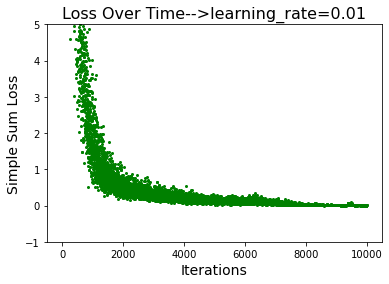

In [38]:
plt.plot(losses, "go", ms=2)
plt.title("Loss Over Time-->learning_rate=0.01", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Simple Sum Loss", fontsize=14)
plt.ylim(-1,5)

In [39]:
losses[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0021129686>

In [109]:
sample_x, sample_y = make_xy_pair(input_shape)
print(sample_x)
print("\n", sample_y)

[[[ 0.93394834  0.88398054  0.85238333 -0.07524273 -0.08039319]
  [ 0.9037738   0.00701798 -0.05267977  0.04158317  0.07841433]
  [ 0.9174065   0.06540756  0.01387241  1.1460097  -0.03262658]
  [ 1.13222987  1.10290178  1.10889811  0.14040132 -0.14343524]
  [-0.13777564  1.08909472  0.11033481  1.01262836  0.91389311]]]

 [[[1. 1. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 1. 0.]
  [1. 1. 1. 0. 0.]
  [0. 1. 0. 1. 1.]]]


In [112]:
out, loss, grad = TFuSoln(prepped_input(sample_x), *model, prepped_output(sample_y))
np.set_printoptions(suppress=True)
print(tf.transpose(out, perm=[3,0,1,2]).numpy(), "\nLoss: ", loss.numpy())

[[[[ 0.88199294  0.96529335  0.96462256 -0.00197578 -0.00280396]
   [ 0.85306376 -0.00211484 -0.0023678  -0.0090771  -0.00128443]
   [ 0.8714334  -0.0060393  -0.00851359  1.011142   -0.01508312]
   [ 1.1011543   0.99681866  1.0308552   0.03121403  0.03881502]
   [-0.16623925  1.056139    0.02582387  0.9533928   0.96875596]]]] 
Loss:  0.10334555


In [42]:
print("Depth of 5, 10,000 iterations with learning rate of 0.01, and a noise factor of 0.3 for input data.")

Depth of 5, 10,000 iterations with learning rate of 0.01, and a noise factor of 0.3 for input data.


Text(0, 0.5, 'Simple Sum Loss')

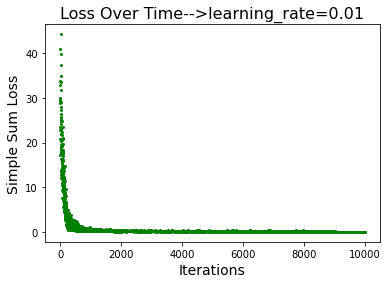

In [86]:
plt.plot(losses, "go", ms=2)
plt.title("Loss Over Time-->learning_rate=0.01", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Simple Sum Loss", fontsize=14)
#plt.ylim(-1,5)

In [87]:
losses[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.009812182>

In [91]:
sample_x, sample_y = make_xy_pair(input_shape)
print(sample_x)

[[[ 0.00546614  0.97742175  0.97430307  0.85680093  0.923272  ]
  [ 0.91690513  0.86135771 -0.11942392  0.94741635  0.89983883]
  [ 0.87914246  1.14956997  0.99850232  0.07408158  1.11756996]
  [ 0.14790601  0.13955127  0.85935673  0.99169955  0.96968548]
  [-0.05533341 -0.12111725  0.11740186 -0.08168785  1.01993711]]]


In [92]:
out, loss, grad = TFuSoln(prepped_input(sample_x), *model, prepped_output(sample_y))
print(tf.transpose(out, perm=[3,0,1,2]).numpy(), "\nLoss: ", loss.numpy())

[[[[-0.00434119  1.0217782   1.000688    1.0019023   1.0056856 ]
   [ 0.9905342   0.98970026 -0.00867928  1.0251889   1.0071673 ]
   [ 0.96516764  1.0112808   1.0205146  -0.01131328  1.0086378 ]
   [ 0.05956297  0.01000294  1.0217316   1.0244684   1.0185547 ]
   [-0.00313789 -0.00781932 -0.00166808 -0.00329247  1.0109689 ]]]] 
Loss:  0.008718401


(-1.0, 5.0)

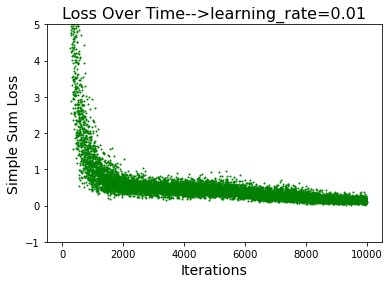

In [99]:
plt.plot(losses, "go", ms=1)
plt.title("Loss Over Time-->learning_rate=0.01", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Simple Sum Loss", fontsize=14)
plt.ylim(-1,5)

In [100]:
losses[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.09115592>